https://www.kaggle.com/datasets/mohamedgobara/multi-class-knee-osteoporosis-x-ray-dataset \
https://www.kaggle.com/datasets/vuppalaadithyasairam/bone-fracture-detection-using-xrays \
https://www.kaggle.com/datasets/daverattan/dental-xrary-tfrecords \
https://www.kaggle.com/datasets/yovinyahathugoda/x-ray-body-part-dataset-512x512

### V6: Find correspondence. Use individual images

# Attention Map

In [1]:
# CONFIG
# model_name = "facebook/dinov3-vits16-pretrain-lvd1689m"
model_name = "facebook/dinov3-vitb16-pretrain-lvd1689m"
# model_name = "facebook/dinov3-vits16plus-pretrain-lvd1689m"
data_dir = "/home/minsukc/SIO/data/"
# target_image_1 = "Chest_X-Ray_1.png"
# target_image_2 = "Chest_X-Ray_1_translated_50_30.png"
# target_image_2 = "Chest_X-Ray_1_translated_100_100.png"
# target_image_1 = "ct_chest_1.jpeg"
# target_image_2 = "ct_chest_1_translated_100_100.jpeg"
target_image_1 = "ct_chest_2.png"
target_image_2 = "ct_chest_2_translated_100_100.png"
# target_image_1 = "CT_Slice_3.jpg"
# target_image_2 = "CT_Slice_3_translated_80_80.jpg"
# target_image_2 = "ct_chest_2_translated_300_300.png"
# target_image_2 = "ct_chest_2.png"
# target_image = "ct_chest_3.jpeg"
# target_image = "ct_dental_1.png"
# target_image = "ct_dental_2.png"
# target_image = "ct_bone_1.jpg"
# target_image = "ct_bone_2.jpeg"
# target_image = "ct_abdomen_1.png"

##### Natural Images #####
# target_image_1 = "_dog.jpg"
# target_image_2 = "_cat.png"
# target_image = "_hen.jpg"
# target_image = "_flamingo.jpg"

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoImageProcessor, AutoModel
from transformers.image_utils import load_image
import os
from PIL import Image

In [3]:
# Load model & image
processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModel.from_pretrained(
    model_name,
    output_attentions=True,
    output_hidden_states=True,
)

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
model.to(device)
print(f"Using device: {device}")

# image = load_image(os.path.join(data_dir, target_image))
# # inputs = processor(images=image, return_tensors="pt").to(device)
# image.size

Using device: cuda


In [4]:
# Load both
image1 = load_image(os.path.join(data_dir, target_image_1))
image2 = load_image(os.path.join(data_dir, target_image_2))

# Match sizes (if different)
w1, h1 = image1.size
w2, h2 = image2.size
target_h = min(h1, h2)
target_w = min(w1, w2)

# resized due to OOM
# target_h = target_h // 2
# target_w = target_w // 2
# target_h = 768
# target_w = 768

resized_image1 = image1.resize((target_w, target_h))
resized_image2 = image2.resize((target_w, target_h))

# 🔹 Concatenate horizontally (side-by-side)
# concat_image = Image.new("RGB", (target_w * 2, target_h))
# concat_image.paste(resized_image1, (0, 0))
# concat_image.paste(resized_image2, (target_w, 0))

# or vertically:
# concat_image = Image.new("RGB", (target_w, target_h * 2))
# concat_image.paste(resized_image1, (0, 0))
# concat_image.paste(resized_image2, (0, target_h))

print("Image 1 size:", image1.size)
print("Image 2 size:", image2.size)
# print("Concatenated image size:", concat_image.size)
# concat_image.show()


Image 1 size: (1024, 1024)
Image 2 size: (1024, 1024)


In [5]:
def encode_dino(img):
    inputs = processor(
        images=img,
        do_resize=False,
        do_center_crop=False,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        out = model(**inputs, interpolate_pos_encoding=True)

    return out

out1 = encode_dino(image1)
out2 = encode_dino(image2)

for i, h in enumerate(out1.hidden_states):
    print(f"Layer {i}: {tuple(h.shape)}")

Layer 0: (1, 4101, 768)
Layer 1: (1, 4101, 768)
Layer 2: (1, 4101, 768)
Layer 3: (1, 4101, 768)
Layer 4: (1, 4101, 768)
Layer 5: (1, 4101, 768)
Layer 6: (1, 4101, 768)
Layer 7: (1, 4101, 768)
Layer 8: (1, 4101, 768)
Layer 9: (1, 4101, 768)
Layer 10: (1, 4101, 768)
Layer 11: (1, 4101, 768)
Layer 12: (1, 4101, 768)


In [6]:
k=-1

In [7]:
_, HA_px, WA_px = out1.hidden_states[0].shape  # or use processor output
patch_size = model.config.patch_size
num_registers = model.config.num_register_tokens

HA = image1.height // patch_size
WA = image1.width  // patch_size
HB = image2.height // patch_size
WB = image2.width  // patch_size

print(HA,WA,HB,WB)

64 64 64 64


In [8]:
def get_cls_attention_map(out, k, patch_h, patch_w):
    attentions = out.attentions
    hidden = out.hidden_states

    attn_k = attentions[k]            # [B, heads, N, N]
    avg_attn = attn_k.mean(dim=1)[0]  # [N, N]

    # 4. CLS → patch attention slice
    cls_attn = avg_attn[0, 1 + num_registers : ]    # length = patch_h * patch_w
    cls_attn = cls_attn.reshape(patch_h, patch_w)

    # 5. Normalize to [0, 1]
    cls_attn = cls_attn.detach().cpu().numpy()
    cls_attn = (cls_attn - cls_attn.min()) / (cls_attn.max() - cls_attn.min())

    return cls_attn

In [9]:
attn_1 = get_cls_attention_map(out1,k,HA,WA)
attn_2 = get_cls_attention_map(out2,k,HB,WB)

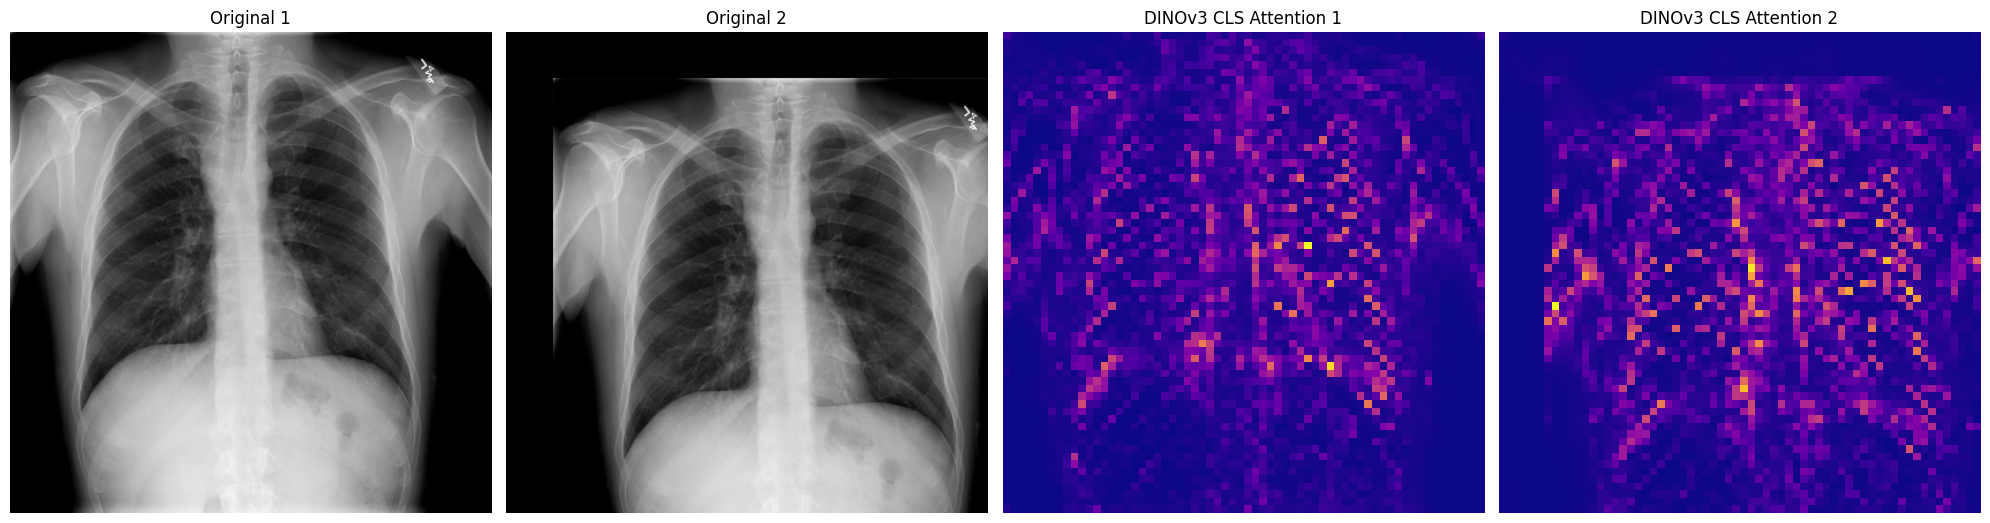

In [10]:
# Create 1×4 grid:
# | Image A | Image B | Attn A | Attn B |
fig, axes = plt.subplots(1, 4, figsize=(20, 6))

# --- ORIGINAL IMAGES ---
axes[0].imshow(image1)
axes[0].set_title("Original 1")
axes[0].axis("off")

axes[1].imshow(image2)
axes[1].set_title("Original 2")
axes[1].axis("off")

# --- ATTENTION MAPS ---
axes[2].imshow(attn_1, cmap="plasma", interpolation="nearest")
axes[2].set_title("DINOv3 CLS Attention 1")
axes[2].axis("off")

axes[3].imshow(attn_2, cmap="plasma", interpolation="nearest")
axes[3].set_title("DINOv3 CLS Attention 2")
axes[3].axis("off")

plt.tight_layout()
plt.show()


# Patch Similarity Map

In [11]:
# # Remove CLS + register tokens to get pure patch embeddings
# layer_feats = outputs.hidden_states[k]    
# patch_feats = layer_feats[:, 1 + model.config.num_register_tokens:, :].squeeze(0)

# # patch_feats = outputs.last_hidden_state[
# #     :, 1 + model.config.num_register_tokens :, :
# # ].squeeze(0)
# print(patch_feats.shape)
# num_patches = patch_feats.shape[0]
# patch_side = int(num_patches**0.5)

In [12]:
# # Create a grid of query patch indices (e.g., 4×4 evenly spaced)
# # grid_size = 4
# # coords = np.linspace(0, patch_side - 1, grid_size, dtype=int)
# # query_indices = [y * patch_side + x for y in coords for x in coords]

# n_queries = len(query_indices)
# cols = grid_size
# rows = grid_size
# print(cols, rows)

In [13]:
# # Compute true patch grid from model input
# _, _, H, W = inputs["pixel_values"].shape
# patch_size = model.config.patch_size
# patch_h, patch_w = H // patch_size, W // patch_size

# # Confirm number of patches matches
# num_patches = patch_feats.shape[0]
# assert num_patches == patch_h * patch_w, (
#     f"Expected {patch_h * patch_w}, got {num_patches}"
# )

# # Create a grid of query patch indices (e.g., 4×4 evenly spaced)
# grid_size = 4
# coords_y = np.linspace(0, patch_h - 1, grid_size, dtype=int)
# coords_x = np.linspace(0, patch_w - 1, grid_size, dtype=int)
# query_indices = [y * patch_w + x for y in coords_y for x in coords_x]

# cols = grid_size
# rows = grid_size
# print(f"Patch grid: {patch_h}x{patch_w}, queries: {len(query_indices)}")

# # ---- Figure setup ----
# fig, axes = plt.subplots(rows, cols + 1, figsize=(4 * (cols + 1), 4 * rows))

# # ---- Left column: original image ----
# for r in range(rows):
#     ax_img = axes[r, 0]
#     ax_img.imshow(image)
#     ax_img.axis("off")

#     # mark all query patch centers
#     for q_idx in query_indices:
#         qy, qx = divmod(q_idx, patch_w)
#         img_w, img_h = image.size
#         center_x = (qx + 0.5) * (img_w / patch_w)
#         center_y = (qy + 0.5) * (img_h / patch_h)
#         ax_img.scatter(
#             center_x,
#             center_y,
#             color="red",
#             s=30,
#             marker="o",
#             edgecolors="black",
#             linewidth=0.5,
#             alpha=0.8,
#         )

# # ---- Right grid: similarity maps ----
# ax_list = []
# for r in range(rows):
#     for c in range(1, cols + 1):
#         ax_list.append(axes[r, c] if rows > 1 else axes[c])

# for ax, q_idx in zip(ax_list, query_indices):
#     query_feat = patch_feats[q_idx : q_idx + 1]
#     sim = torch.nn.functional.cosine_similarity(query_feat, patch_feats)
#     sim_map = sim.reshape(patch_h, patch_w).cpu().numpy()  # ✅ correct shape
#     sim_map = (sim_map - sim_map.min()) / (sim_map.max() - sim_map.min())

#     qy, qx = divmod(q_idx, patch_w)
#     ax.imshow(sim_map, cmap="plasma", interpolation="nearest")
#     # ax.imshow(sim_map, cmap="plasma", interpolation="bilinear")
#     ax.scatter(qx, qy, color="red", s=40, marker="o", edgecolors="black", linewidth=0.5)
#     ax.set_title(f"({qx}, {qy})", fontsize=10)
#     ax.axis("off")

# print(sim_map.shape)  # type: ignore
# plt.suptitle("DINOv3 Patch Similarity", fontsize=16)
# plt.tight_layout()
# plt.show()


# PCA

In [14]:
from sklearn.decomposition import PCA

def pca_feature_map(outputs, k):
    # 1. Extract patch embeddings (same as before)
    layer_feats = outputs.hidden_states[k]
    patch_feats = layer_feats[:, 1 + num_registers :, :].squeeze(0)

    feats = patch_feats.cpu().numpy()  # [N, dim]

    # 2. PCA → RGB
    pca = PCA(n_components=3)
    pca_feats = pca.fit_transform(feats)

    pca_min = pca_feats.min(axis=0, keepdims=True)
    pca_max = pca_feats.max(axis=0, keepdims=True)
    pca_norm = (pca_feats - pca_min) / (pca_max - pca_min + 1e-8)

    # 4. Reshape to (Hpatch × Wpatch × 3)
    pca_img = pca_norm.reshape(HA, WA, 3)

    return pca_img


In [15]:
pca_1 = pca_feature_map(out1, k)
pca_2 = pca_feature_map(out2, k)


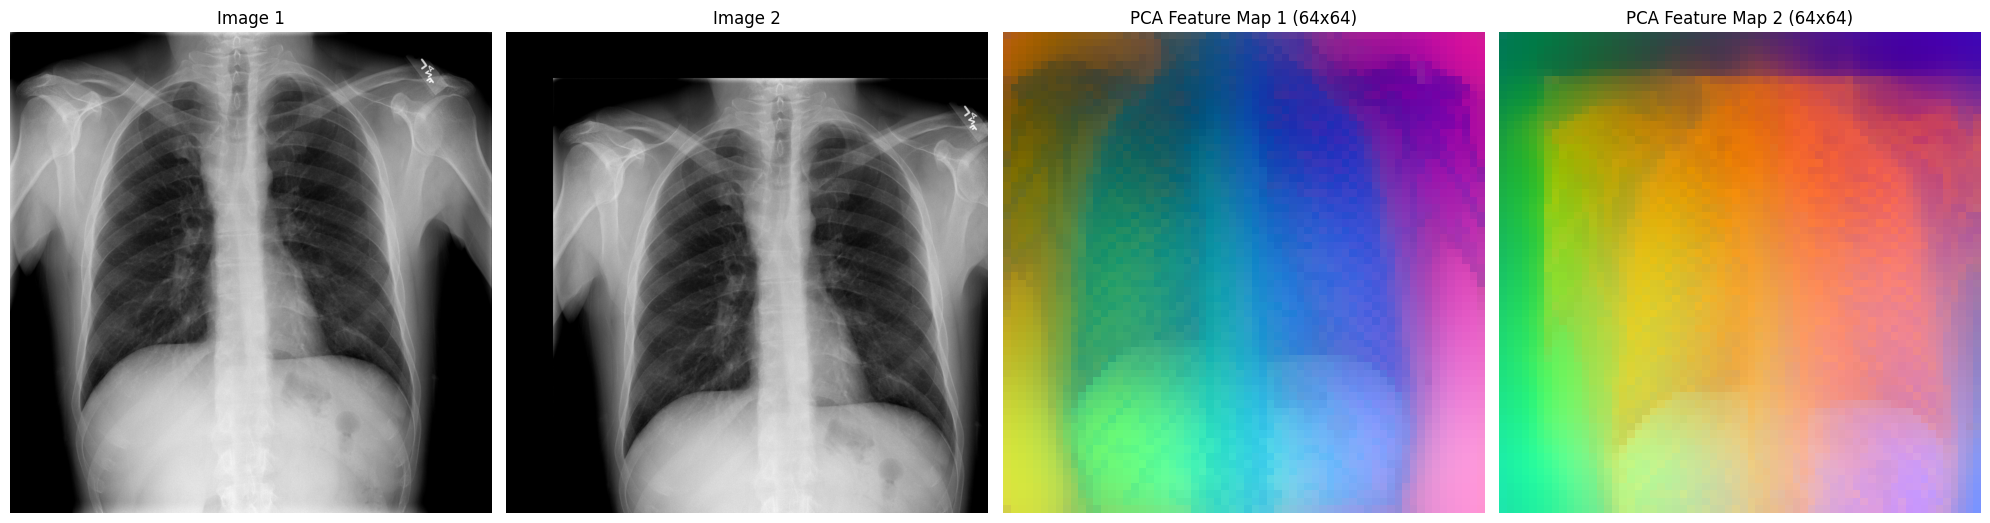

In [16]:
fig, axes = plt.subplots(1, 4, figsize=(20, 6))

axes[0].imshow(image1)
axes[0].set_title("Image 1")
axes[0].axis("off")

axes[1].imshow(image2)
axes[1].set_title("Image 2")
axes[1].axis("off")

axes[2].imshow(pca_1, interpolation="nearest")
axes[2].set_title(f"PCA Feature Map 1 ({HA}x{WA})")
axes[2].axis("off")

axes[3].imshow(pca_2, interpolation="nearest")
axes[3].set_title(f"PCA Feature Map 2 ({HB}x{WB})")
axes[3].axis("off")

plt.tight_layout()
plt.show()


# Correspondence

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def draw_correspondences(
    imgA,
    imgB,
    HA,
    WA,
    HB,
    WB,
    match_B,
    num_samples=None,  # None = draw all
    sampling="grid",  # "grid" or "random"
):
    imgA = np.array(imgA)
    imgB = np.array(imgB)

    # match_B length = number of A patches
    N_A = len(match_B)

    # ---------------------------
    # 1) Determine patch indices to draw
    # ---------------------------
    if num_samples is None or num_samples >= N_A:
        indices = np.arange(N_A)
    else:
        if sampling == "grid":
            # pick evenly spaced indices
            indices = np.linspace(0, N_A - 1, num_samples, dtype=int)
        elif sampling == "random":
            indices = np.random.choice(N_A, num_samples, replace=False)
        else:
            raise ValueError("sampling must be 'grid' or 'random'")

    # ---------------------------
    # 2) Resize images to same height
    # ---------------------------
    h = max(imgA.shape[0], imgB.shape[0])
    imgA2 = cv2.resize(imgA, (imgA.shape[1], h))
    imgB2 = cv2.resize(imgB, (imgB.shape[1], h))

    # side-by-side canvas
    canvas = np.concatenate([imgA2, imgB2], axis=1)

    # ---------------------------
    # 3) Patch grid scaling
    # ---------------------------
    stepA_x = imgA2.shape[1] / WA
    stepA_y = h / HA
    stepB_x = imgB2.shape[1] / WB
    stepB_y = h / HB

    # ---------------------------
    # 4) Draw sampled correspondences
    # ---------------------------
    for i in indices:
        b_idx = match_B[i]

        # A patch center
        Ay = (i // WA) * stepA_y + stepA_y / 2
        Ax = (i % WA) * stepA_x + stepA_x / 2

        # B patch center
        By = (b_idx // WB) * stepB_y + stepB_y / 2
        Bx = (b_idx % WB) * stepB_x + stepB_x / 2 + imgA2.shape[1]

        pA = (int(Ax), int(Ay))
        pB = (int(Bx), int(By))

        # draw dots
        cv2.circle(canvas, pA, 5, (255, 0, 0), -1)  # blue dot on A
        cv2.circle(canvas, pB, 5, (0, 0, 255), -1)  # red dot on B

        # connect them
        cv2.line(canvas, pA, pB, (0, 255, 0), 2)
        # scale = 0.1  # shorten arrows
        # cv2.arrowedLine(
        #     canvas,
        #     pA,
        #     (int(pA[0] + scale*(pB[0]-pA[0])),
        #      int(pA[1] + scale*(pB[1]-pA[1]))),
        #     (0, 255, 0),
        #     2,
        #     tipLength=0.1
        # )


    # ---------------------------
    # 5) Display
    # ---------------------------
    plt.figure(figsize=(14, 6))
    plt.imshow(canvas)
    plt.axis("off")
    plt.title("Patch Correspondence Lines")
    plt.show()


In [18]:
def compute_correspondence(sim, WA, HA, WB, HB, r=None):
    """
    sim: [N_A, N_B] similarity matrix
    r: search radius (None = global search)
    """
    N_A = sim.shape[0]

    # Flattened B-grid coordinates (yB, xB)
    coords_y_B = np.arange(HB).repeat(WB)
    coords_x_B = np.tile(np.arange(WB), HB)

    match_B = []

    for i in range(N_A):
        # coords of patch i in A
        yA = i // WA
        xA = i % WA

        if r is None:  # -----------------------------------
            # GLOBAL SEARCH (no limits)
            # -----------------------------------------------
            best_j = sim[i].argmax().item()
            match_B.append(best_j)
            continue

        # -----------------------------------------------
        # LOCAL SEARCH within radius r
        # -----------------------------------------------
        y_min = max(0, yA - r)
        y_max = min(HB - 1, yA + r)
        x_min = max(0, xA - r)
        x_max = min(WB - 1, xA + r)

        # mask valid B patches
        mask = (
            (coords_y_B >= y_min)
            & (coords_y_B <= y_max)
            & (coords_x_B >= x_min)
            & (coords_x_B <= x_max)
        )

        valid_scores = sim[i][mask]
        valid_indices = np.where(mask)[0]

        best_j = valid_indices[valid_scores.argmax().item()]
        match_B.append(best_j)

    return np.array(match_B)


In [19]:
def get_patch_features(out, k):
    layer = out.hidden_states[k]
    print(layer.shape)
    num_registers = model.config.num_register_tokens
    patch_feats = layer[:, 1 + num_registers:, :]
    return patch_feats.squeeze(0)   # [N, 384]

patch1 = get_patch_features(out1, k)
patch2 = get_patch_features(out2, k)

patch1_norm = torch.nn.functional.normalize(patch1, dim=-1)
patch2_norm = torch.nn.functional.normalize(patch2, dim=-1)

sim = patch1_norm @ patch2_norm.T

torch.Size([1, 4101, 768])
torch.Size([1, 4101, 768])


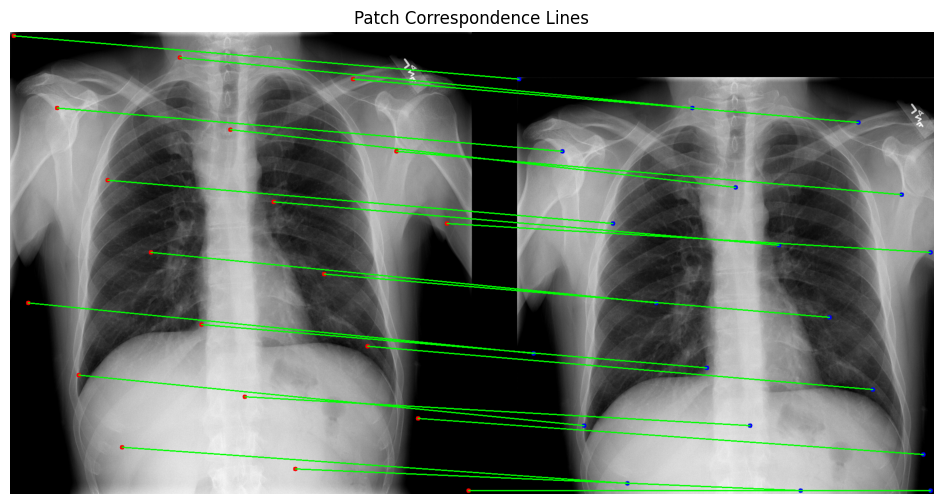

In [20]:
match_B = compute_correspondence(sim, WA, HA, WB, HB, r=None)
draw_correspondences(
    image1,
    image2,
    HA, WA,
    HB, WB,
    match_B,
    num_samples=20,
    sampling="grid"
)

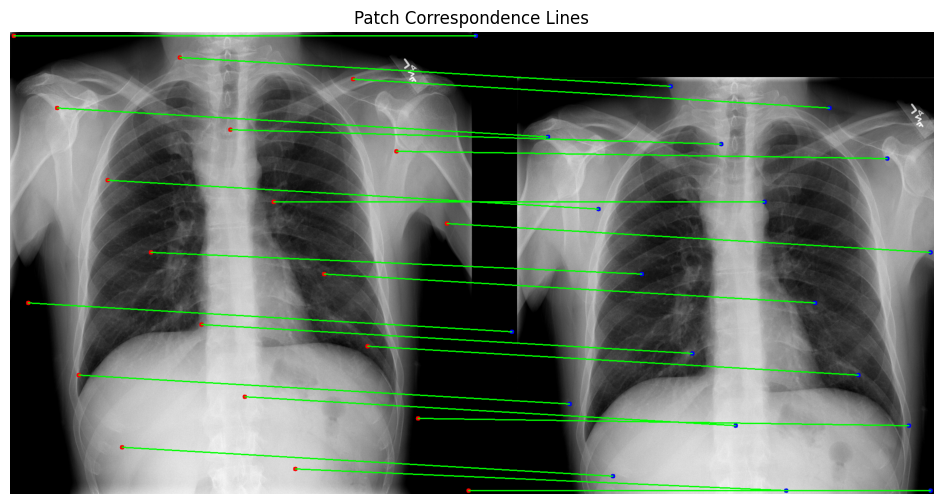

In [21]:
match_B = compute_correspondence(sim, WA, HA, WB, HB, r=4)
draw_correspondences(
    image1,
    image2,
    HA, WA,
    HB, WB,
    match_B,
    num_samples=20,
    sampling="grid"
)

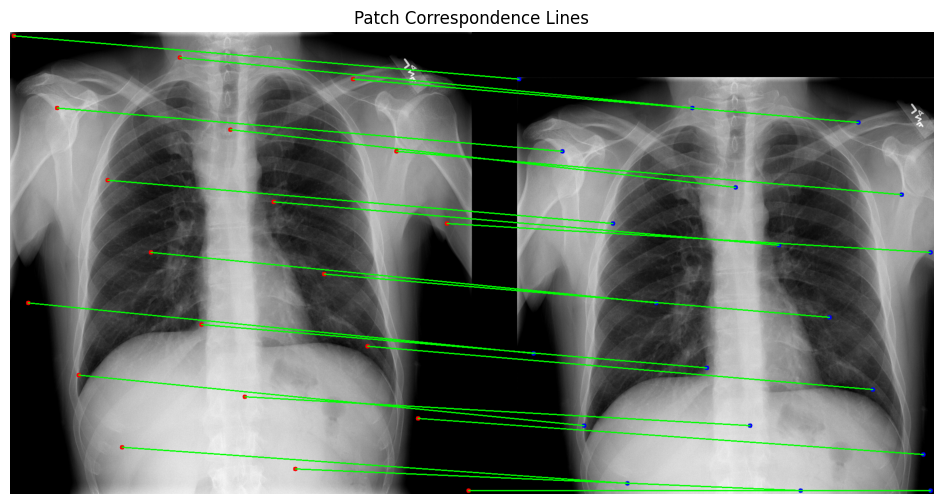

In [22]:
match_B = compute_correspondence(sim, WA, HA, WB, HB, r=10)
draw_correspondences(
    image1,
    image2,
    HA, WA,
    HB, WB,
    match_B,
    num_samples=20,
    sampling="grid"
)

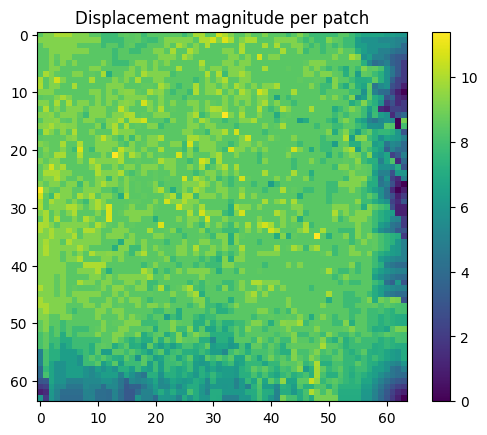

In [23]:
dx = np.zeros(len(match_B))
dy = np.zeros(len(match_B))

for i, b_idx in enumerate(match_B):
    yA = i // WA; xA = i % WA
    yB = b_idx // WB; xB = b_idx % WB
    dx[i] = xB - xA
    dy[i] = yB - yA

dx_img = dx.reshape(HA, WA)
dy_img = dy.reshape(HA, WA)
mag_img = np.sqrt(dx_img**2 + dy_img**2)
plt.imshow(mag_img, cmap="viridis")
plt.colorbar()
plt.title("Displacement magnitude per patch")
plt.show()


Mean pixel error: 24.987880852182215
Median pixel error: 12.649110640673518
Max pixel error: 192.0833152566875
Std pixel error: 28.602002736122262


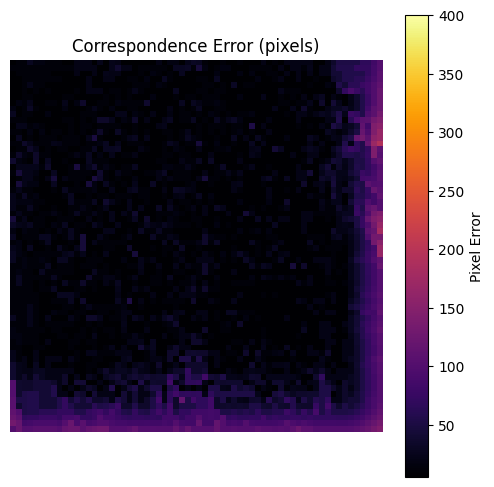

In [24]:
import numpy as np
import matplotlib.pyplot as plt


def compute_error_map(match_B, HA, WA, HB, WB, image_width, image_height,
                      true_dx, true_dy):
    """
    match_B: correspondence indices for each A patch (len N_A = HA*WA)
    true_dx, true_dy: known translation in pixels
    """

    # -----------------------------
    # 1. Patch center coordinates in A (patch space)
    # -----------------------------
    xs_A = np.tile(np.arange(WA), HA)       # [0..WA-1, repeated]
    ys_A = np.repeat(np.arange(HA), WA)     # [0..HA-1, tiled]

    # -----------------------------
    # 2. Convert match_B into patch coords in B
    # -----------------------------
    xs_B = np.array([j % WB for j in match_B])
    ys_B = np.array([j // WB for j in match_B])

    # -----------------------------
    # 3. Displacement in patch units
    # -----------------------------
    dx_patch = xs_B - xs_A
    dy_patch = ys_B - ys_A

    # -----------------------------
    # 4. Convert patch-displacement → pixel displacement
    # -----------------------------
    patch_w_px = image_width  / WA    # px per patch width
    patch_h_px = image_height / HA    # px per patch height

    dx_px = dx_patch * patch_w_px
    dy_px = dy_patch * patch_h_px

    # -----------------------------
    # 5. Compute pixel-level error vs known motion
    # -----------------------------
    error_x = dx_px - true_dx
    error_y = dy_px - true_dy

    error_mag = np.sqrt(error_x**2 + error_y**2)

    # -----------------------------
    # 6. Reshape back to patch grid
    # -----------------------------
    error_img_px = error_mag.reshape(HA, WA)

    return error_img_px



# ----------------------------------------------------
# Example usage with your variables
# ----------------------------------------------------

# image1, image2 are PIL Images after resizing
img_w, img_h = image1.size

# Your known translation (e.g. from filename)
true_dx = 100   # pixels
true_dy = 100   # pixels

# Compute error map
# match_B = compute_correspondence(sim, Wp, H, Wp, H, r=None)
match_B = compute_correspondence(sim, WA, HA, WB, HB, r=10)
# match_B = compute_correspondence(sim, Wp, H, Wp, H, r=15)
error_img_px = compute_error_map(
    match_B,
    HA, WA,
    HB, WB,
    image_width=img_w,
    image_height=img_h,
    true_dx=true_dx,
    true_dy=true_dy
)

# Optional summary statistics
print("Mean pixel error:", np.mean(error_img_px))
print("Median pixel error:", np.median(error_img_px))
print("Max pixel error:", np.max(error_img_px))
print("Std pixel error:", np.std(error_img_px))


# ----------------------------------------------------
# Display heatmap
# ----------------------------------------------------
plt.figure(figsize=(6,6))
# plt.imshow(error_img_px, cmap="inferno")
plt.imshow(error_img_px, cmap="inferno", vmax=400)
plt.title("Correspondence Error (pixels)")
plt.colorbar(label="Pixel Error")
plt.axis("off")
plt.show()

